# PCA Reduction and model training

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LinearRegression as LR

First we preprocess the data in order to perform the PCA reduction over the selected data

In [2]:
directorio = '../newfile/latpar_project/LatPars_SuperModel/'

hfxrd = np.load(directorio + 'hf_0100.npy')
y = np.load('../newfile/latpar_project/latpars.npy')

db = pd.read_csv('../newfile/latpar_project/db_peaks.csv')

dftest = pd.read_csv(directorio + 'dftest.csv')
dftraval = pd.read_csv(directorio + 'dftraval.csv')

for row in range(db.shape[0]):    
    db.at[row,'name'] = db['name'][row][:7]
    
dftest = pd.read_csv(directorio + 'dftest.csv')
dftraval = pd.read_csv(directorio + 'dftraval.csv')

for row in range(dftest.shape[0]):
    dftest.at[row, 'name'] = dftest['name'][row][:7]
    
for row in range(dftraval.shape[0]):
    dftraval.at[row, 'name'] = dftraval['name'][row][:7]

ntest = dftest.shape[0]//4
ntraval = dftraval.shape[0]//4

dftest = dftest.iloc[:ntest,:].reset_index(drop=True)
dftraval = dftraval.iloc[:ntraval,:].reset_index(drop=True)

idxtraval = [i for i in db.loc[db.name.isin([i.split('_')[0] for i in dftraval.name.values])].index]
idxtest = [i for i in db.loc[db.name.isin([i.split('_')[0] for i in dftest.name.values])].index]


hftest = hfxrd[idxtest]
hftraval = hfxrd[idxtraval]
    
ytest = y[idxtest]
ytraval = y[idxtraval]

#### PCA For hftraval and hftest

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [4]:
pcatraval = PCA()
pcatest = PCA()
pcahf = PCA()

pcatraval.fit(hftraval)
pcatest.fit(hftest)
pcahf.fit(hfxrd)

xtrans_traval = pcatraval.transform(hftraval)
xtrans_test = pcatest.transform(hftest)
xtrans_hf = pcahf.transform(hfxrd)

vartraval = pcatraval.explained_variance_ratio_
vartest = pcatest.explained_variance_ratio_
varhf = pcahf.explained_variance_ratio_

cum_traval = np.cumsum(vartraval)
cum_test = np.cumsum(vartest)
cum_hf = np.cumsum(varhf)

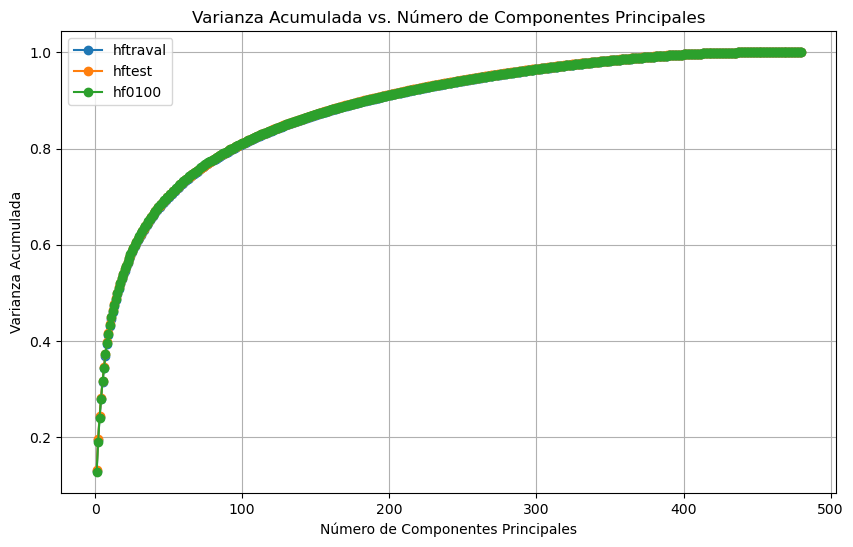

In [5]:
# Graficar la varianza acumulada contra el número de componentes principales
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cum_traval) + 1), cum_traval, marker='o', linestyle='-', label='hftraval')
plt.plot(range(1, len(cum_test) + 1), cum_test, marker='o', linestyle='-', label='hftest')
plt.plot(range(1, len(cum_hf) + 1), cum_hf, marker='o', linestyle='-', label='hf0100')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada')
plt.title('Varianza Acumulada vs. Número de Componentes Principales')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
#componentes mayores al 80% de la varianza
vartraval_80 = xtrans_traval[:, cum_traval <= 0.8]

#componentes mayores al 95% de la varianza
vartraval_95 = xtrans_traval[:, cum_traval <= 0.95]

# Equivalentes test
vartest_80 = xtrans_test[:, cum_traval <= 0.8]
vartest_95 = xtrans_test[:, cum_traval <= 0.95]

In [10]:
print(f"Number of components needed to retain 80% variance: {vartraval_80.shape[1]} \nNumber of components needed to retain 95% variance: {vartraval_95.shape[1]}")

Number of components needed to retain 80% variance: 93 
Number of components needed to retain 95% variance: 267


In [11]:
vartraval_95.shape, vartraval_80.shape

((205331, 267), (205331, 93))

# Model training with PCA

Now, we are going to replicate the Models_extension and Models_extension_wo_xrd neural networks with the pca transformed variables.

In [16]:
def create_mlp(features = int, multiples = list, dropout = 0, name= 'multilayer_nn'):
    input_layer = tf.keras.Input((features))

    for n, hl in enumerate(multiples):

        if n == 0: x = tf.keras.layers.Dense(hl*features)(input_layer)
        else: x = tf.keras.layers.Dense(hl*features)(x)

        x = tf.keras.layers.LayerNormalization()(x)

        if n != len(multiples) -1:
            x = tf.keras.layers.LeakyReLU(0.15)(x)
            x = tf.keras.layers.Dropout(dropout)(x)

    xs = tf.keras.layers.Dense(multiples[-1]*features)(input_layer)
    xs = tf.keras.layers.LayerNormalization()(xs)

    x = tf.keras.layers.Add()([x, xs])
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dropout(dropout)(x)

    x = tf.keras.layers.Dense(6)(x)

    return tf.keras.models.Model(inputs=input_layer, outputs=x, name=name)


In [21]:
# Model Settings

multiples = [6,8]
epochs = 25
batch_size = 64
verbose = 1
dropout = 0.5

#### Raw PCA 80% variance

C:\Users\lmich\anaconda3\Lib\site-packages\keras\src\optimizers\legacy\adamax.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/25


3209/3209 [==============================] - 40s 12ms/step - loss: 0.3439 - mean_squared_error: 1.2662 - val_loss: 0.4730 - val_mean_squared_error: 1.9531
Epoch 2/25
   7/3209 [..............................] - ETA: 26s - loss: 0.2057 - mean_squared_error: 0.6081

C:\Users\lmich\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3209/3209 [==============================] - 41s 13ms/step - loss: 0.1955 - mean_squared_error: 0.5667 - val_loss: 0.4670 - val_mean_squared_error: 1.9594
Epoch 3/25
3209/3209 [==============================] - 39s 12ms/step - loss: 0.1734 - mean_squared_error: 0.4853 - val_loss: 0.4562 - val_mean_squared_error: 1.9229
Epoch 4/25
3209/3209 [==============================] - 39s 12ms/step - loss: 0.1617 - mean_squared_error: 0.4454 - val_loss: 0.4633 - val_mean_squared_error: 1.9787
Epoch 5/25
3209/3209 [==============================] - 42s 13ms/step - loss: 0.1530 - mean_squared_error: 0.4169 - val_loss: 0.4551 - val_mean_squared_error: 1.9378
Epoch 6/25
3209/3209 [==============================] - 38s 12ms/step - loss: 0.1475 - mean_squared_error: 0.3986 - val_loss: 0.4590 - val_mean_squared_error: 1.9662
Epoch 7/25
3209/3209 [==============================] - 39s 12ms/step - loss: 0.1432 - mean_squared_error: 0.3848 - val_loss: 0.4590 - val_mean_squared_error: 1.9672
Epoch 8/25
3209

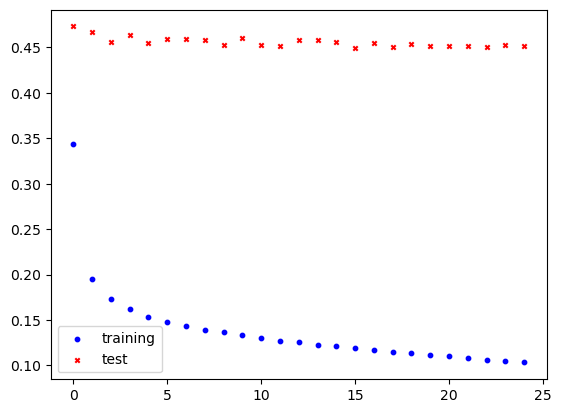

In [44]:
features = vartraval_80.shape[-1]


modelo_pca80 = create_mlp(features = features, multiples = multiples, dropout = dropout, name='pca_80')


modelo_pca80.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.legacy.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))

saveas = 'model_pca_80'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_pca80.fit(vartraval_80,ytraval, validation_data=(vartest_80,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

loss_log = data.history['loss']
val_loss_log = data.history['val_loss']
mat = np.vstack((loss_log, val_loss_log)).T
dataframe1 = pd.DataFrame(data=mat)
dataframe1.to_csv(str(saveas)+'.csv', sep=',', header=False, float_format='%.7f', index=False)

plt.figure()
plt.scatter(np.arange(mat.shape[0]), mat[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.shape[0]), mat[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

#### Raw PCA 95

Epoch 1/25
3209/3209 [==============================] - 85s 26ms/step - loss: 0.2469 - mean_squared_error: 0.7851 - val_loss: 0.4781 - val_mean_squared_error: 2.0075
Epoch 2/25
3209/3209 [==============================] - 87s 27ms/step - loss: 0.1258 - mean_squared_error: 0.3274 - val_loss: 0.4685 - val_mean_squared_error: 1.9911
Epoch 3/25
3209/3209 [==============================] - 85s 27ms/step - loss: 0.1104 - mean_squared_error: 0.2800 - val_loss: 0.4685 - val_mean_squared_error: 1.9976
Epoch 4/25
3209/3209 [==============================] - 84s 26ms/step - loss: 0.1021 - mean_squared_error: 0.2560 - val_loss: 0.4662 - val_mean_squared_error: 1.9887
Epoch 5/25
3209/3209 [==============================] - 84s 26ms/step - loss: 0.0966 - mean_squared_error: 0.2403 - val_loss: 0.4676 - val_mean_squared_error: 2.0063
Epoch 6/25
3209/3209 [==============================] - 86s 27ms/step - loss: 0.0930 - mean_squared_error: 0.2302 - val_loss: 0.4606 - val_mean_squared_error: 1.9798
Epoc

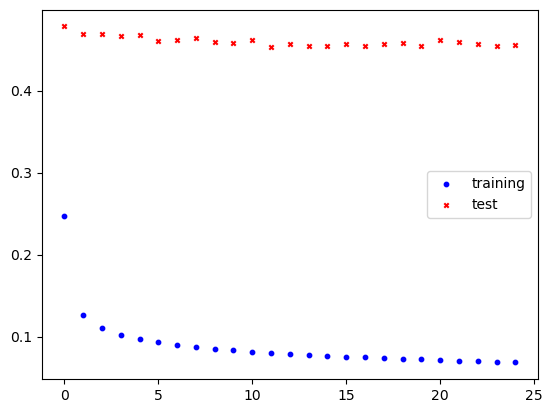

In [48]:
features = vartraval_95.shape[-1]


modelo_pca95 = create_mlp(features = features, multiples = multiples, dropout = dropout, name='pca_95')


modelo_pca95.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.legacy.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))

saveas = 'model_pca_95'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_pca95.fit(vartraval_95,ytraval, validation_data=(vartest_95,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

loss_log = data.history['loss']
val_loss_log = data.history['val_loss']
mat = np.vstack((loss_log, val_loss_log)).T
dataframe1 = pd.DataFrame(data=mat)
dataframe1.to_csv(str(saveas)+'.csv', sep=',', header=False, float_format='%.7f', index=False)

plt.figure()
plt.scatter(np.arange(mat.shape[0]), mat[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.shape[0]), mat[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

In [44]:
modelo_pca80 = tf.keras.models.load_model('model_pca_80.h5')
modelo_pca95 = tf.keras.models.load_model('model_pca_95.h5')


483/483 [==============================] - 4s 6ms/step


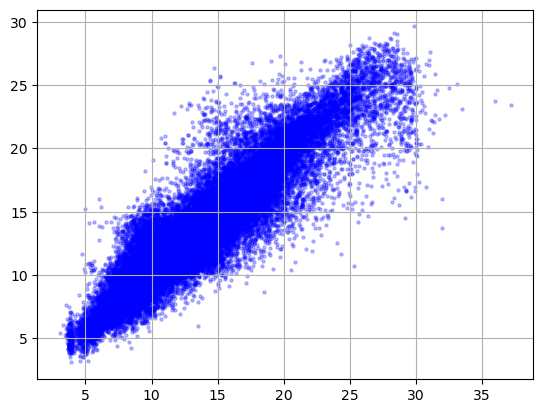

1.9559217452810986
483/483 [==============================] - 5s 9ms/step


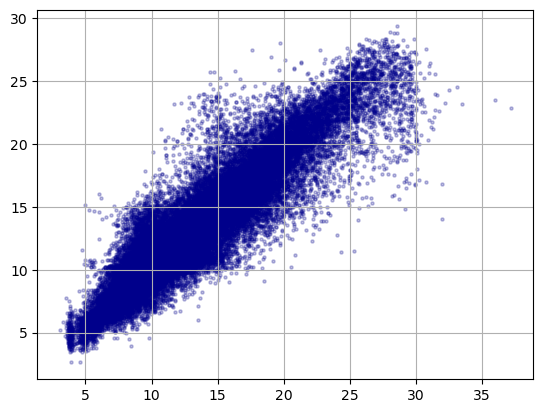

1.9722478363401208


In [12]:
ptestnn = modelo_pca80.predict(vartest_80)
    
plt.figure()
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=5, color='blue', alpha=0.25)
plt.grid()
plt.show()
    
rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5
print(rmse)

ptestnn = modelo_pca95.predict(vartest_95)
    
plt.figure()
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=5, color='darkblue', alpha=0.25)
plt.grid()
plt.show()
    
rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5
print(rmse)


155/155 [==============================] - 1s 4ms/step


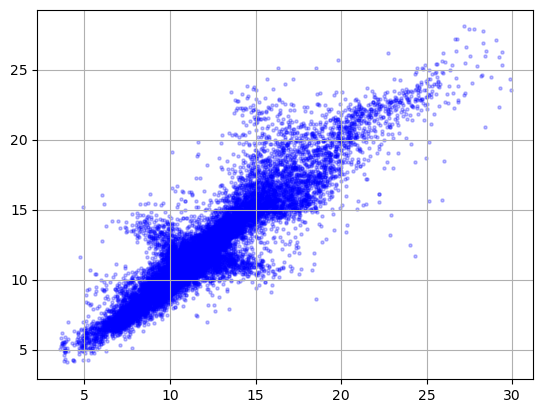

1.5319647410741324
251/251 [==============================] - 1s 3ms/step


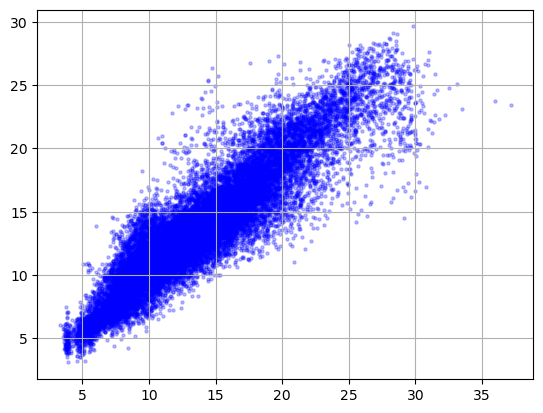

2.1362804136715074
67/67 [==============================] - 0s 3ms/step


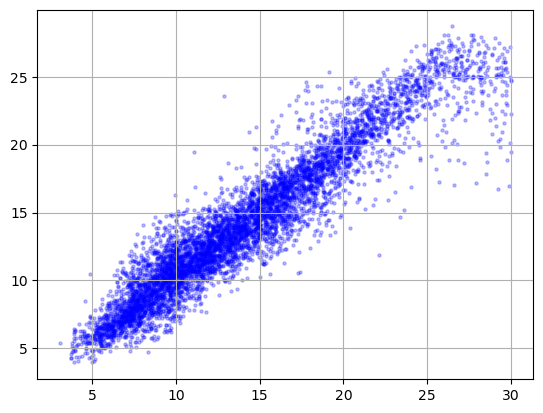

1.8475415656653091
7/7 [==============================] - 0s 2ms/step


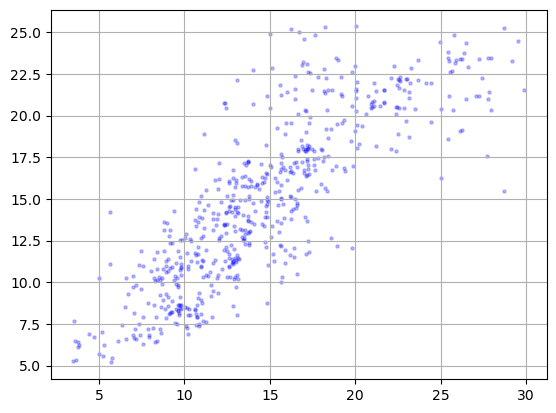

2.997099255523535
4/4 [==============================] - 0s 4ms/step


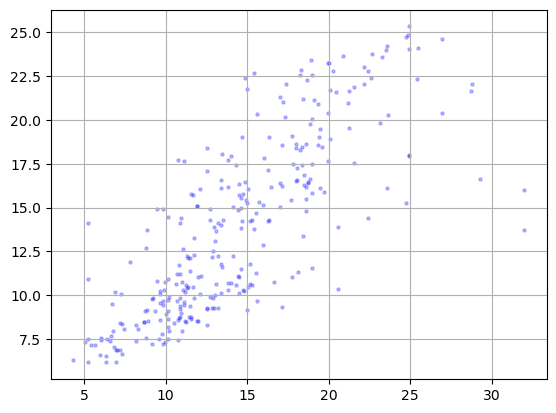

3.418463722928876
2/2 [==============================] - 0s 0s/step


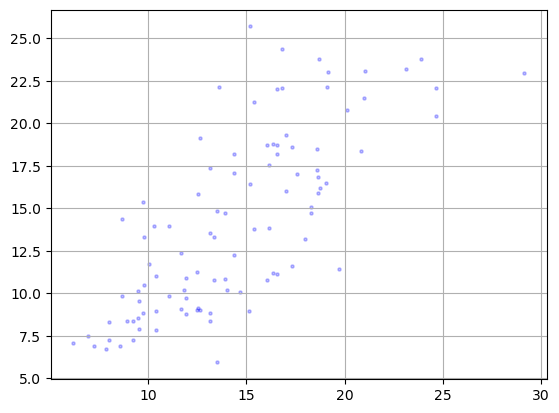

3.532144746469311
1/1 [==============================] - 0s 20ms/step


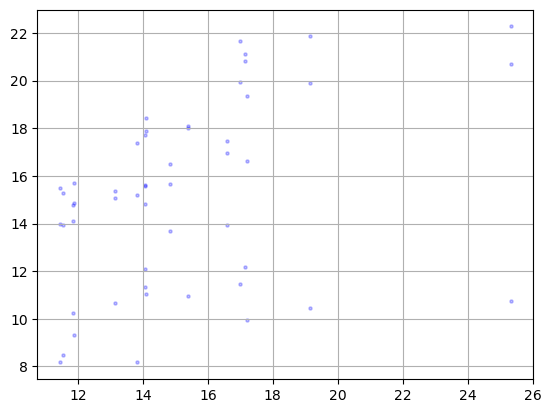

3.9346918698151465
155/155 [==============================] - 1s 7ms/step


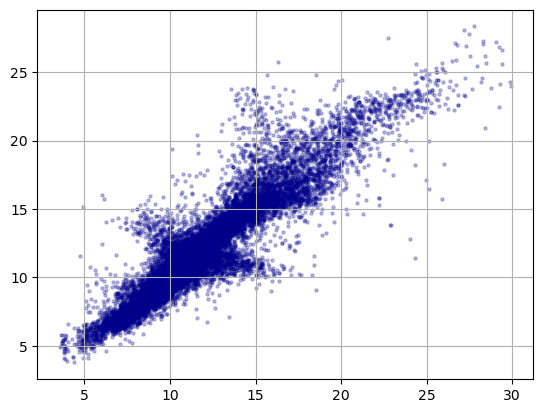

1.5696787262151828
251/251 [==============================] - 2s 7ms/step


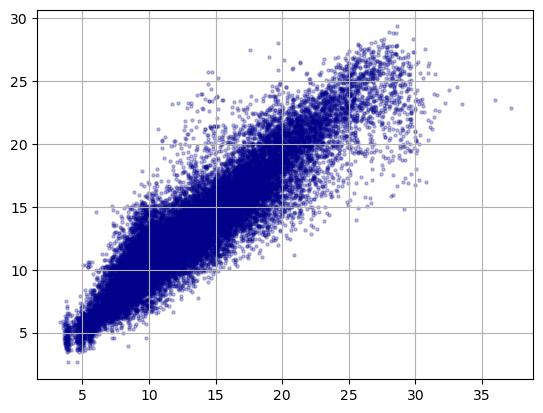

2.1587090741886237
67/67 [==============================] - 0s 6ms/step


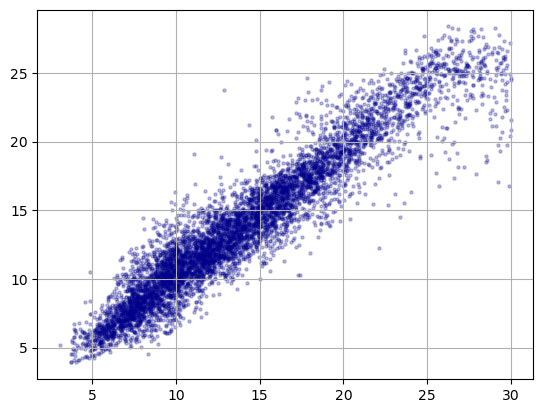

1.81969308003261
7/7 [==============================] - 0s 6ms/step


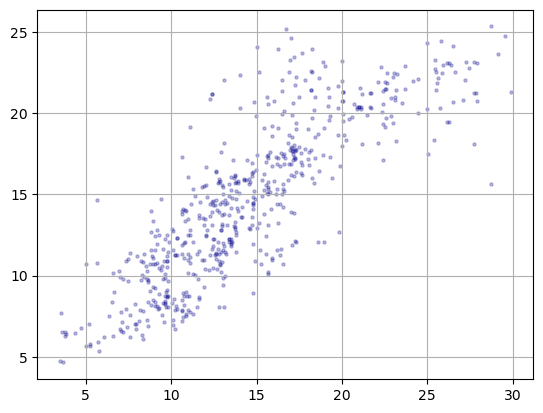

2.9357804481457275
4/4 [==============================] - 0s 3ms/step


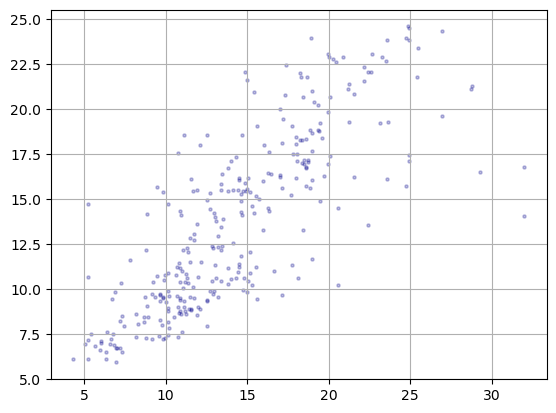

3.3688014007273
2/2 [==============================] - 0s 5ms/step


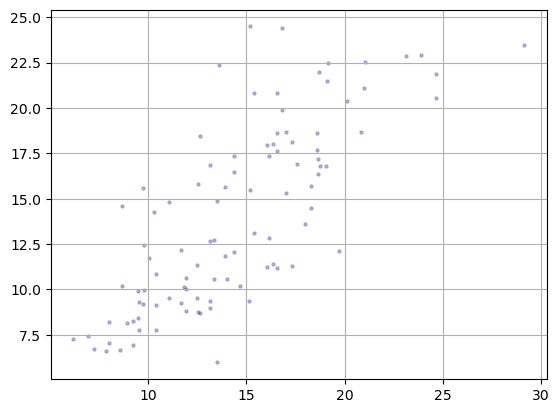

3.318406698533775
1/1 [==============================] - 0s 37ms/step


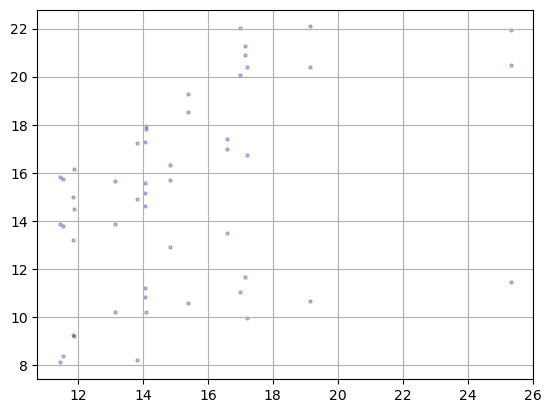

4.018931730990202


In [46]:
crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : vartest_80[system],
                                  'y': ytest[system] }

    
for i in range(7):
    
    ptestnn = modelo_pca80.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='blue', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    print(rmse)

crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : vartest_95[system],
                                  'y': ytest[system] }

    
for i in range(7):
    
    ptestnn = modelo_pca95.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='darkblue', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    print(rmse)

# Modelos PCA + space groups

In [17]:
sgdiccio = pd.read_csv('../newfile/latpar_project/sgnum_cif.csv')
sgdiccio = {k:v for k,v in zip(sgdiccio.cif.values, sgdiccio.sgnum.values)}

dbtest = db.take(idxtest).reset_index(drop=True)
dbtraval = db.take(idxtraval).reset_index(drop=True)

dbtest['sgnum'] = [sgdiccio.get(int(i), None) for i in dbtest.name.values]
dbtraval['sgnum'] = [sgdiccio.get(int(i), None) for i in dbtraval.name.values]

In [18]:
sgoset = scipy.stats.ortho_group.rvs(230, random_state=3451)
sgos_traval = sgoset[dbtraval.sgnum.values-1]
sgos_test = sgoset[dbtest.sgnum.values-1]

##### Modelo pca 80 + space groups

In [19]:
spgtest80 = np.concatenate((vartest_80, sgos_test), axis=-1)
spgtraval80 = np.concatenate((vartraval_80, sgos_traval), axis=-1)

C:\Users\lmich\anaconda3\Lib\site-packages\keras\src\optimizers\legacy\adamax.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/25


3209/3209 [==============================] - 105s 32ms/step - loss: 0.2368 - mean_squared_error: 0.7464 - val_loss: 0.4470 - val_mean_squared_error: 1.8242
Epoch 2/25


C:\Users\lmich\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3209/3209 [==============================] - 100s 31ms/step - loss: 0.1210 - mean_squared_error: 0.3143 - val_loss: 0.4509 - val_mean_squared_error: 1.8785
Epoch 3/25
3209/3209 [==============================] - 101s 31ms/step - loss: 0.1067 - mean_squared_error: 0.2710 - val_loss: 0.4359 - val_mean_squared_error: 1.8279
Epoch 4/25
3209/3209 [==============================] - 101s 31ms/step - loss: 0.0995 - mean_squared_error: 0.2498 - val_loss: 0.4455 - val_mean_squared_error: 1.8753
Epoch 5/25
3209/3209 [==============================] - 100s 31ms/step - loss: 0.0944 - mean_squared_error: 0.2352 - val_loss: 0.4341 - val_mean_squared_error: 1.8108
Epoch 6/25
3209/3209 [==============================] - 101s 32ms/step - loss: 0.0910 - mean_squared_error: 0.2259 - val_loss: 0.4322 - val_mean_squared_error: 1.8139
Epoch 7/25
3209/3209 [==============================] - 101s 31ms/step - loss: 0.0883 - mean_squared_error: 0.2184 - val_loss: 0.4319 - val_mean_squared_error: 1.8137
Epoch 8/2

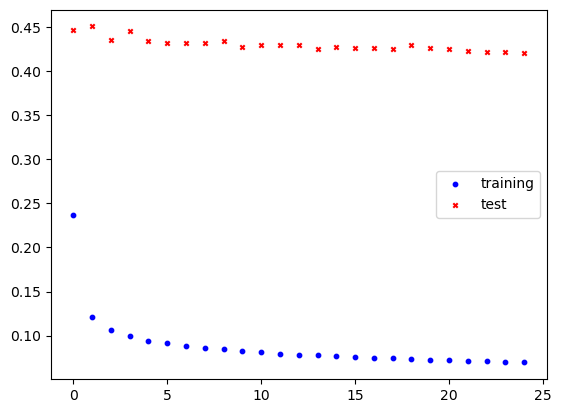

In [22]:
features = spgtraval80.shape[-1]


modelo_pca80_spg = create_mlp(features = features, multiples = multiples, dropout = dropout, name='pca_80_spg')


modelo_pca80_spg.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.legacy.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))

saveas = 'modelo_pca80_spg'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_pca80_spg.fit(spgtraval80,ytraval, validation_data=(spgtest80,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

loss_log = data.history['loss']
val_loss_log = data.history['val_loss']
mat = np.vstack((loss_log, val_loss_log)).T
dataframe1 = pd.DataFrame(data=mat)
dataframe1.to_csv(str(saveas)+'.csv', sep=',', header=False, float_format='%.7f', index=False)

plt.figure()
plt.scatter(np.arange(mat.shape[0]), mat[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.shape[0]), mat[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

##### Modelo pca 95 + space groups

In [23]:
spgtest95 = np.concatenate((vartest_95, sgos_test), axis=-1)
spgtraval95 = np.concatenate((vartraval_95, sgos_traval), axis=-1)

Epoch 1/25
3209/3209 [==============================] - 216s 67ms/step - loss: 0.2416 - mean_squared_error: 0.7780 - val_loss: 0.4781 - val_mean_squared_error: 1.9798
Epoch 2/25
3209/3209 [==============================] - 215s 67ms/step - loss: 0.1081 - mean_squared_error: 0.2728 - val_loss: 0.4538 - val_mean_squared_error: 1.8959
Epoch 3/25
3209/3209 [==============================] - 214s 67ms/step - loss: 0.0938 - mean_squared_error: 0.2313 - val_loss: 0.4602 - val_mean_squared_error: 1.9242
Epoch 4/25
3209/3209 [==============================] - 215s 67ms/step - loss: 0.0863 - mean_squared_error: 0.2107 - val_loss: 0.4532 - val_mean_squared_error: 1.9062
Epoch 5/25
3209/3209 [==============================] - 215s 67ms/step - loss: 0.0817 - mean_squared_error: 0.1979 - val_loss: 0.4487 - val_mean_squared_error: 1.9145
Epoch 6/25
3209/3209 [==============================] - 213s 67ms/step - loss: 0.0778 - mean_squared_error: 0.1877 - val_loss: 0.4531 - val_mean_squared_error: 1.913

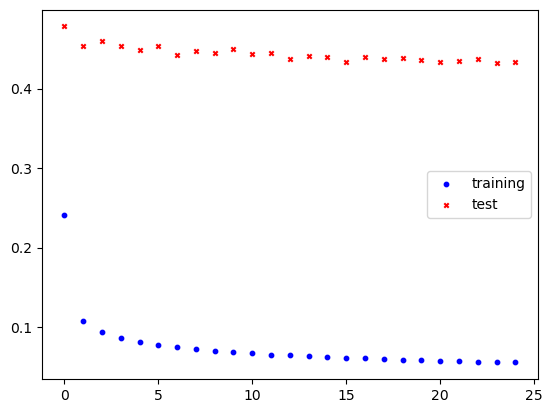

In [26]:
features = spgtraval95.shape[-1]


modelo_pca95_spg = create_mlp(features = features, multiples = multiples, dropout = dropout, name='pca_80_spg')


modelo_pca95_spg.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.legacy.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))

saveas = 'modelo_pca95_spg'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_pca95_spg.fit(spgtraval95,ytraval, validation_data=(spgtest95,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

loss_log = data.history['loss']
val_loss_log = data.history['val_loss']
mat = np.vstack((loss_log, val_loss_log)).T
dataframe1 = pd.DataFrame(data=mat)
dataframe1.to_csv(str(saveas)+'.csv', sep=',', header=False, float_format='%.7f', index=False)

plt.figure()
plt.scatter(np.arange(mat.shape[0]), mat[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.shape[0]), mat[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

In [47]:
modelo_pca80_spg = tf.keras.models.load_model('modelo_pca80_spg.h5')
modelo_pca95_spg = tf.keras.models.load_model('modelo_pca95_spg.h5')


483/483 [==============================] - 4s 8ms/step


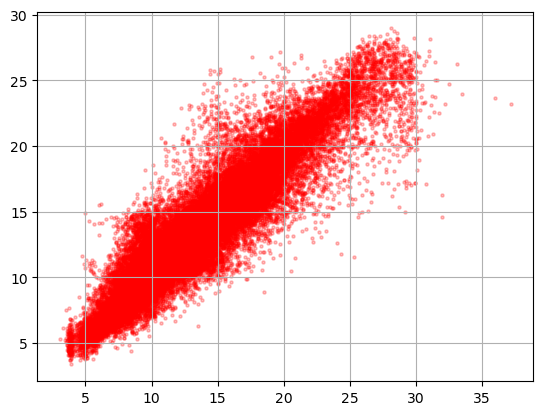

1.8731249070879379
483/483 [==============================] - 5s 10ms/step


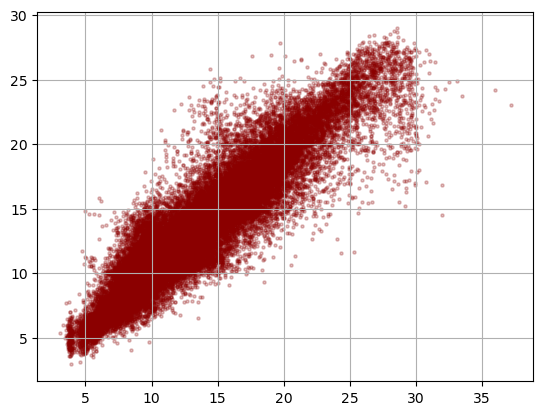

1.8997706471986178


In [30]:
ptestnn = modelo_pca80_spg.predict(spgtest80)
    
plt.figure()
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=5, color='red', alpha=0.25)
plt.grid()
plt.show()
    
rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5
print(rmse)

ptestnn = modelo_pca95_spg.predict(spgtest95)
    
plt.figure()
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=5, color='darkred', alpha=0.25)
plt.grid()
plt.show()
    
rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5
print(rmse)


155/155 [==============================] - 1s 8ms/step


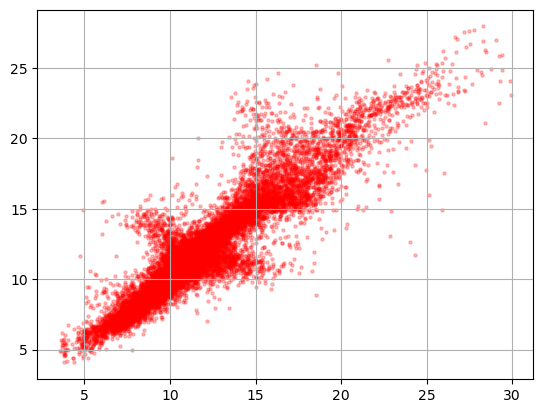

1.5108835345010716
251/251 [==============================] - 2s 8ms/step


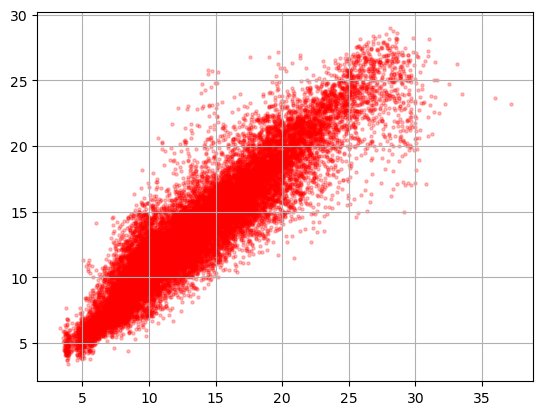

2.0311126206469887
67/67 [==============================] - 1s 8ms/step


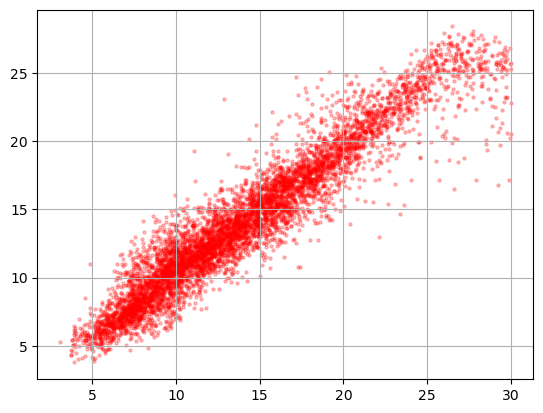

1.751833390102812
7/7 [==============================] - 0s 7ms/step


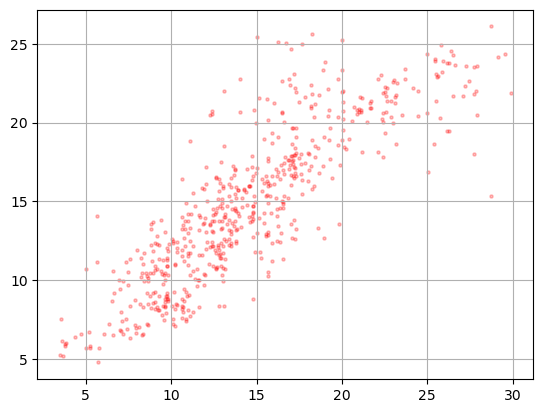

2.852203385846705
4/4 [==============================] - 0s 7ms/step


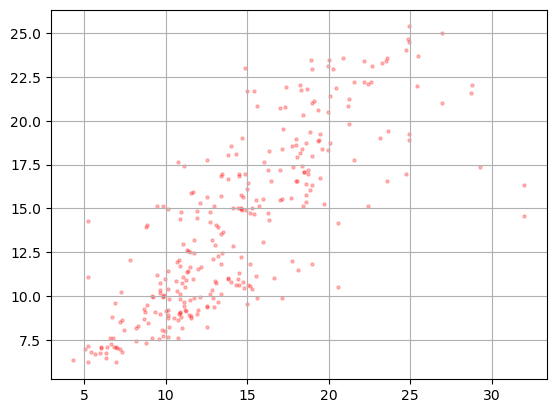

3.26762829514997
2/2 [==============================] - 0s 10ms/step


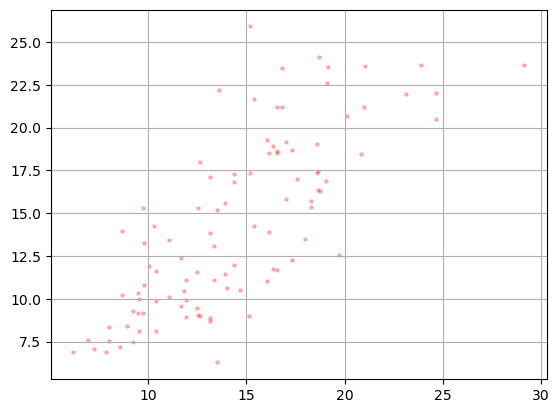

3.3585905373507736
1/1 [==============================] - 0s 36ms/step


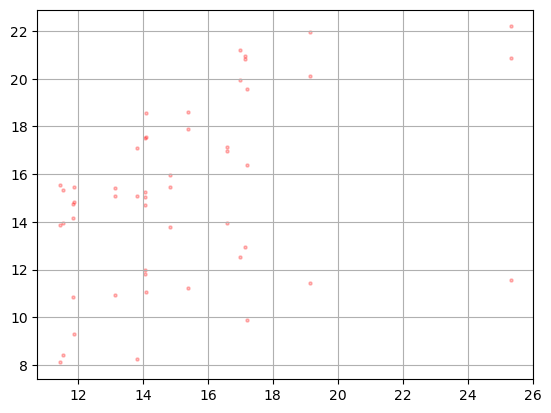

3.7409946513389465
155/155 [==============================] - 2s 11ms/step


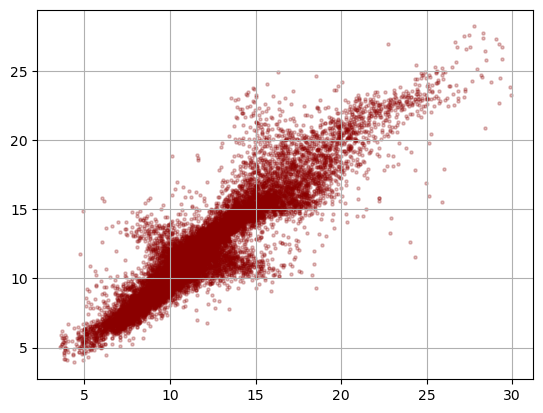

1.499370258895136
251/251 [==============================] - 3s 10ms/step


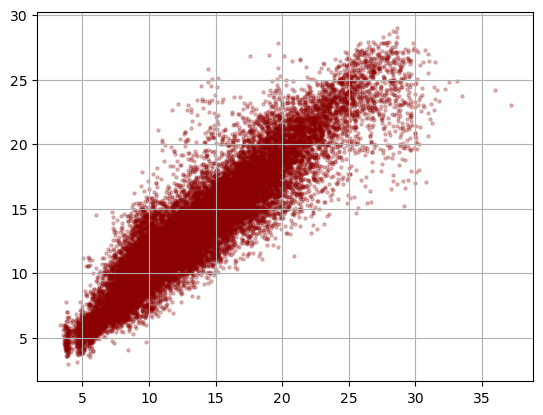

2.0777395527162237
67/67 [==============================] - 1s 10ms/step


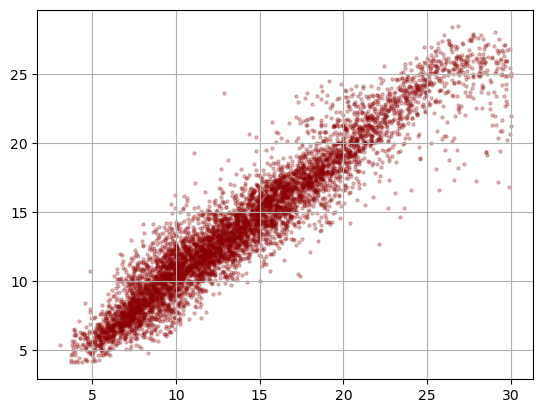

1.779571226472281
7/7 [==============================] - 0s 11ms/step


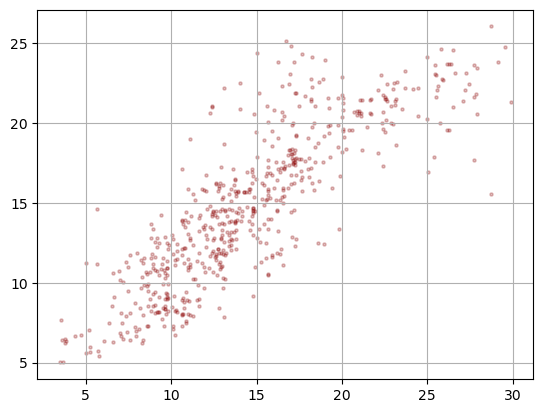

2.8823421823426822
4/4 [==============================] - 0s 11ms/step


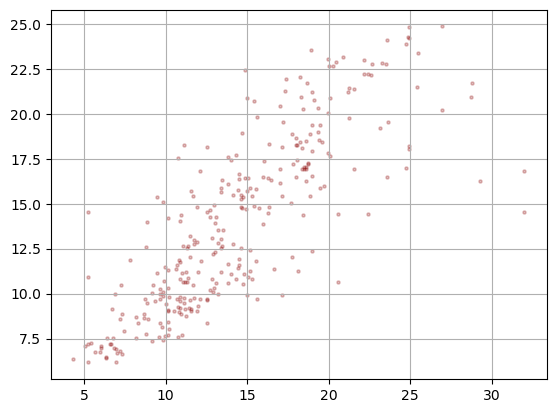

3.2098852284242048
2/2 [==============================] - 0s 7ms/step


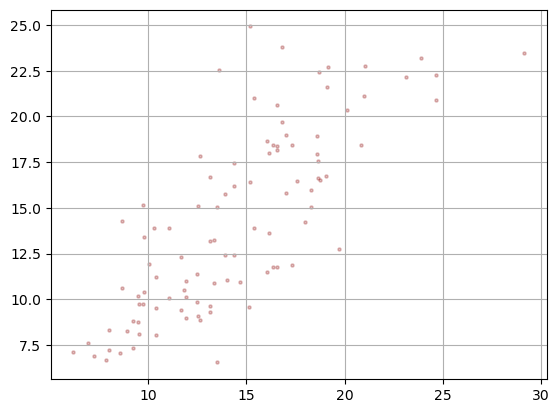

3.15516425477577
1/1 [==============================] - 0s 29ms/step


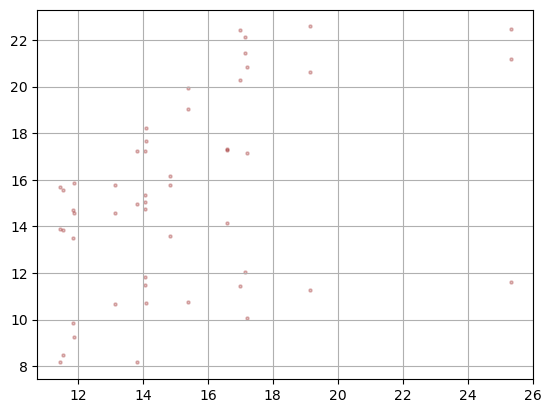

3.954291124835


In [49]:
crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : spgtest80[system],
                                  'y': ytest[system] }

    
for i in range(7):
    
    ptestnn = modelo_pca80_spg.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='red', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    print(rmse)

crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : spgtest95[system],
                                  'y': ytest[system] }

    
for i in range(7):
    
    ptestnn = modelo_pca95_spg.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='darkred', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    print(rmse)

# Modelos PCA +crystal systems

In [31]:
cs = dict()

for n in range(1,231):
    
    if n <= 2: cs[n]  = 0;
    elif 2 < n <=15: cs[n] = 1;
    elif 15 < n <=74: cs[n] = 2;
    elif 74 < n <=142: cs[n] = 3;
    elif 142 < n <=167: cs[n] = 4;
    elif 167 < n <=194: cs[n] = 5;
    elif 194 < n <=230: cs[n] = 6;

dbtest['cs'] = [cs.get(i, None) for i in dbtest.sgnum.values]
dbtraval['cs'] = [cs.get(i, None) for i in dbtraval.sgnum.values]

orthoset = scipy.stats.ortho_group.rvs(32, random_state=3451)
csos_test = orthoset[dbtest.cs.values]
csos_traval = orthoset[dbtraval.cs.values]

#### Modelo PCA 80 + crystal systems

In [32]:
rctest80 = np.concatenate((vartest_80, csos_test), axis=-1)
rctraval80 = np.concatenate((vartraval_80, csos_traval), axis=-1)

C:\Users\lmich\anaconda3\Lib\site-packages\keras\src\optimizers\legacy\adamax.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/25
3209/3209 [==============================] - 49s 15ms/step - loss: 0.3019 - mean_squared_error: 1.0532 - val_loss: 0.4614 - val_mean_squared_error: 1.8871
Epoch 2/25
   6/3209 [..............................] - ETA: 34s - loss: 0.1825 - mean_squared_error: 0.5079

C:\Users\lmich\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3209/3209 [==============================] - 48s 15ms/step - loss: 0.1701 - mean_squared_error: 0.4763 - val_loss: 0.4503 - val_mean_squared_error: 1.8467
Epoch 3/25
3209/3209 [==============================] - 49s 15ms/step - loss: 0.1520 - mean_squared_error: 0.4133 - val_loss: 0.4470 - val_mean_squared_error: 1.8638
Epoch 4/25
3209/3209 [==============================] - 51s 16ms/step - loss: 0.1420 - mean_squared_error: 0.3808 - val_loss: 0.4465 - val_mean_squared_error: 1.8726
Epoch 5/25
3209/3209 [==============================] - 50s 15ms/step - loss: 0.1350 - mean_squared_error: 0.3579 - val_loss: 0.4387 - val_mean_squared_error: 1.8295
Epoch 6/25
3209/3209 [==============================] - 50s 15ms/step - loss: 0.1302 - mean_squared_error: 0.3431 - val_loss: 0.4444 - val_mean_squared_error: 1.8699
Epoch 7/25
3209/3209 [==============================] - 48s 15ms/step - loss: 0.1266 - mean_squared_error: 0.3316 - val_loss: 0.4387 - val_mean_squared_error: 1.8331
Epoch 8/25
3209

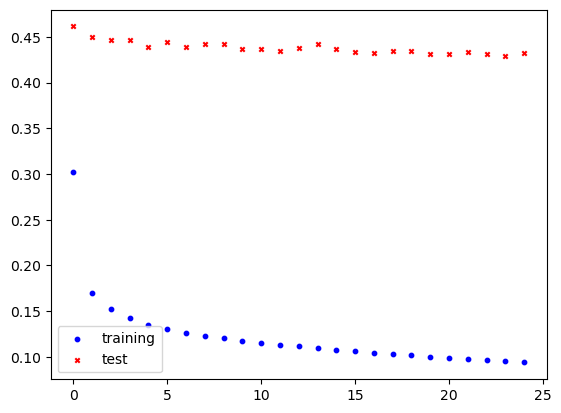

In [33]:
features = rctest80.shape[-1]


modelo_pca80_cs = create_mlp(features = features, multiples = multiples, dropout = dropout, name='pca_80_cs')


modelo_pca80_cs.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.legacy.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))

saveas = 'modelo_pca80_cs'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_pca80_cs.fit(rctraval80,ytraval, validation_data=(rctest80,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

loss_log = data.history['loss']
val_loss_log = data.history['val_loss']
mat = np.vstack((loss_log, val_loss_log)).T
dataframe1 = pd.DataFrame(data=mat)
dataframe1.to_csv(str(saveas)+'.csv', sep=',', header=False, float_format='%.7f', index=False)

plt.figure()
plt.scatter(np.arange(mat.shape[0]), mat[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.shape[0]), mat[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

#### Modelo PCA 95 + crystal systems

In [36]:
rctest95 = np.concatenate((vartest_95, csos_test), axis=-1)
rctraval95 = np.concatenate((vartraval_95, csos_traval), axis=-1)

Epoch 1/25
3209/3209 [==============================] - 99s 30ms/step - loss: 0.2458 - mean_squared_error: 0.7748 - val_loss: 0.4650 - val_mean_squared_error: 1.9031
Epoch 2/25
3209/3209 [==============================] - 96s 30ms/step - loss: 0.1224 - mean_squared_error: 0.3176 - val_loss: 0.4623 - val_mean_squared_error: 1.9150
Epoch 3/25
3209/3209 [==============================] - 97s 30ms/step - loss: 0.1062 - mean_squared_error: 0.2680 - val_loss: 0.4553 - val_mean_squared_error: 1.9206
Epoch 4/25
3209/3209 [==============================] - 97s 30ms/step - loss: 0.0984 - mean_squared_error: 0.2450 - val_loss: 0.4521 - val_mean_squared_error: 1.9066
Epoch 5/25
3209/3209 [==============================] - 96s 30ms/step - loss: 0.0929 - mean_squared_error: 0.2298 - val_loss: 0.4464 - val_mean_squared_error: 1.8825
Epoch 6/25
3209/3209 [==============================] - 97s 30ms/step - loss: 0.0890 - mean_squared_error: 0.2187 - val_loss: 0.4494 - val_mean_squared_error: 1.8877
Epoc

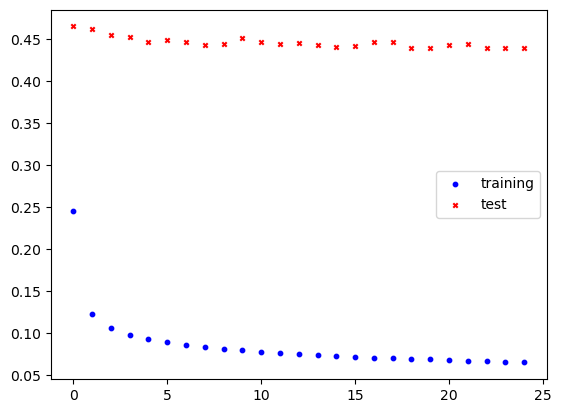

In [37]:
features = rctest95.shape[-1]


modelo_pca95_cs = create_mlp(features = features, multiples = multiples, dropout = dropout, name='pca_95_cs')


modelo_pca95_cs.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.legacy.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))

saveas = 'modelo_pca95_cs'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_pca95_cs.fit(rctraval95,ytraval, validation_data=(rctest95,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

loss_log = data.history['loss']
val_loss_log = data.history['val_loss']
mat = np.vstack((loss_log, val_loss_log)).T
dataframe1 = pd.DataFrame(data=mat)
dataframe1.to_csv(str(saveas)+'.csv', sep=',', header=False, float_format='%.7f', index=False)

plt.figure()
plt.scatter(np.arange(mat.shape[0]), mat[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.shape[0]), mat[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

In [39]:
modelo_pca80_cs = tf.keras.models.load_model('modelo_pca80_cs.h5')
modelo_pca95_cs = tf.keras.models.load_model('modelo_pca95_cs.h5')

483/483 [==============================] - 2s 3ms/step


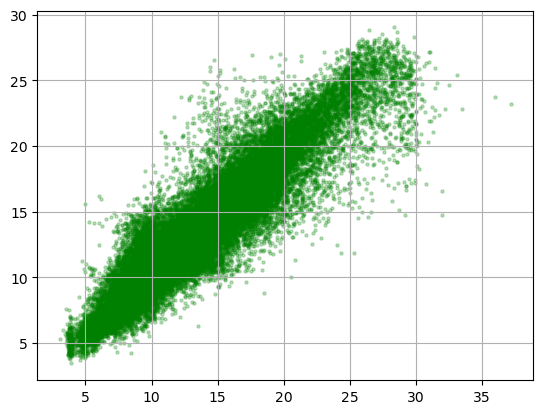

1.8991882858596298
483/483 [==============================] - 3s 7ms/step


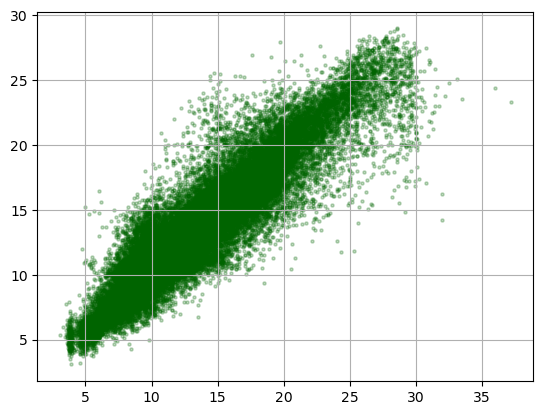

1.9164895760801464


In [40]:
ptestnn = modelo_pca80_cs.predict(rctest80)
    
plt.figure()
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=5, color='green', alpha=0.25)
plt.grid()
plt.show()
    
rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5
print(rmse)

ptestnn = modelo_pca95_cs.predict(rctest95)
    
plt.figure()
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=5, color='darkgreen', alpha=0.25)
plt.grid()
plt.show()
    
rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5
print(rmse)


155/155 [==============================] - 1s 4ms/step


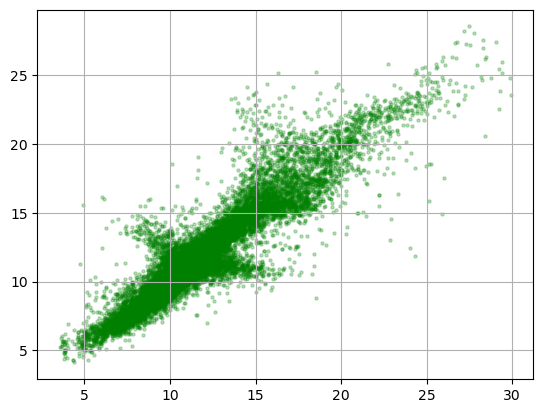

1.4797735384504722
251/251 [==============================] - 1s 4ms/step


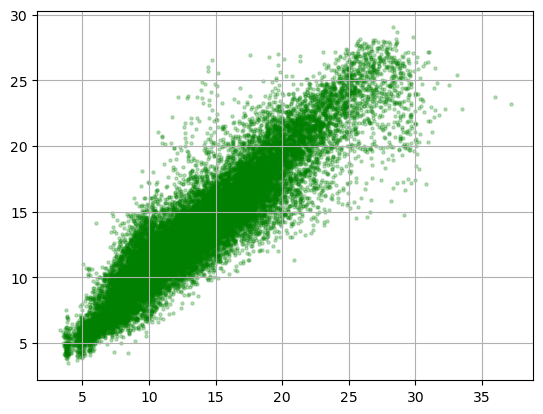

2.0767964426972987
67/67 [==============================] - 0s 4ms/step


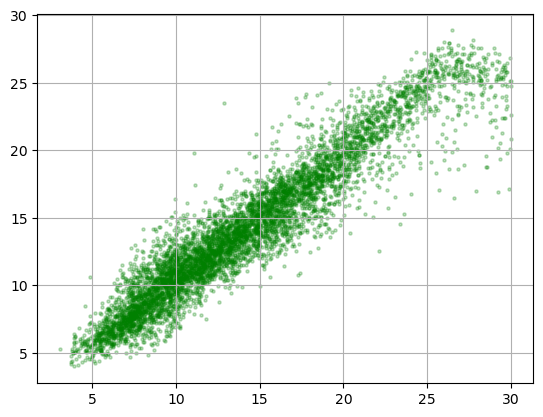

1.8124053273282419
7/7 [==============================] - 0s 4ms/step


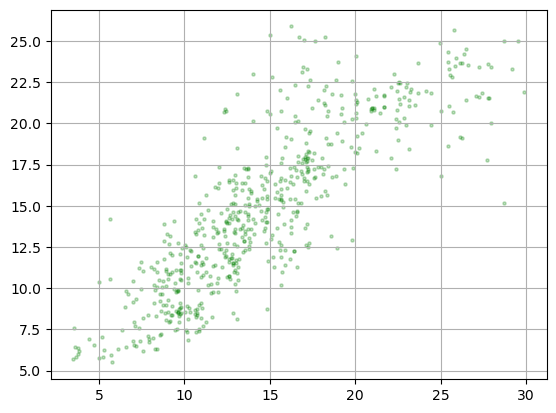

2.9114356894691293
4/4 [==============================] - 0s 6ms/step


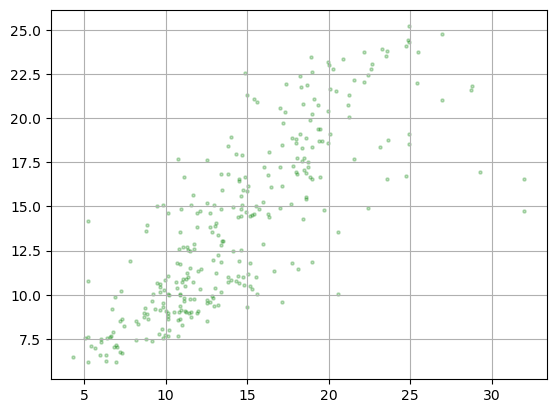

3.2463128551018157
2/2 [==============================] - 0s 5ms/step


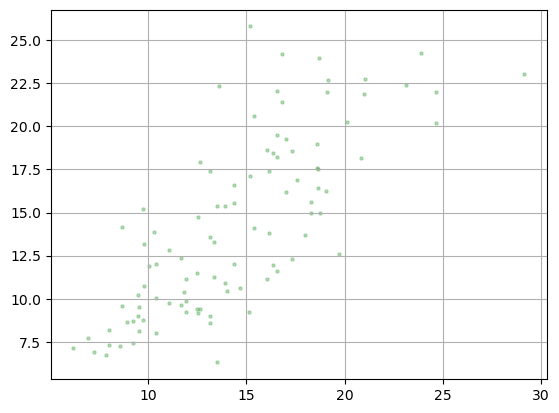

3.339861896703467
1/1 [==============================] - 0s 24ms/step


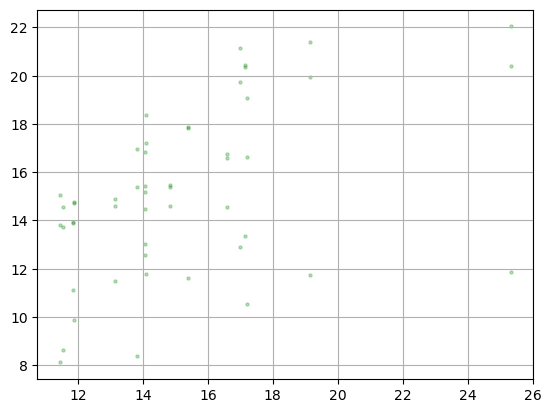

3.466400511350687
155/155 [==============================] - 1s 7ms/step


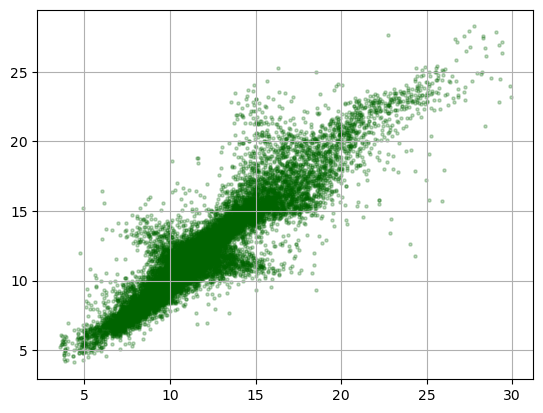

1.4948412692999775
251/251 [==============================] - 2s 8ms/step


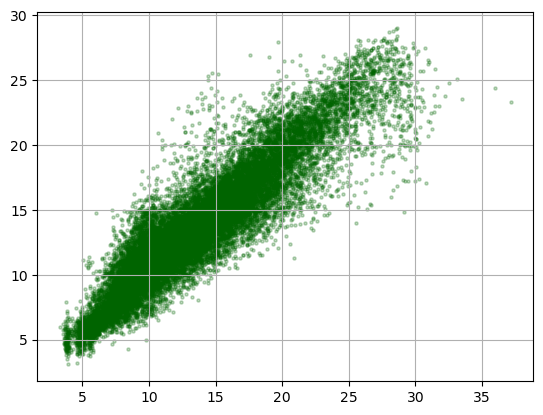

2.1055218161427973
67/67 [==============================] - 0s 7ms/step


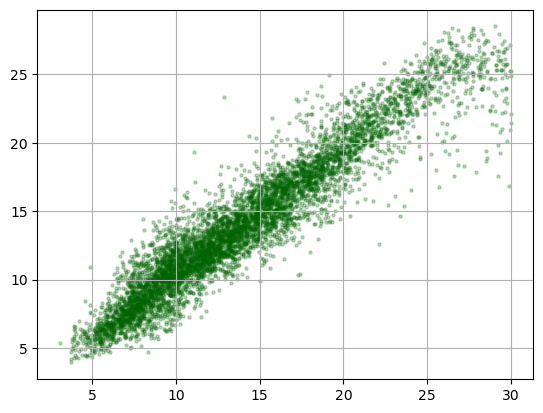

1.7990985403350432
7/7 [==============================] - 0s 5ms/step


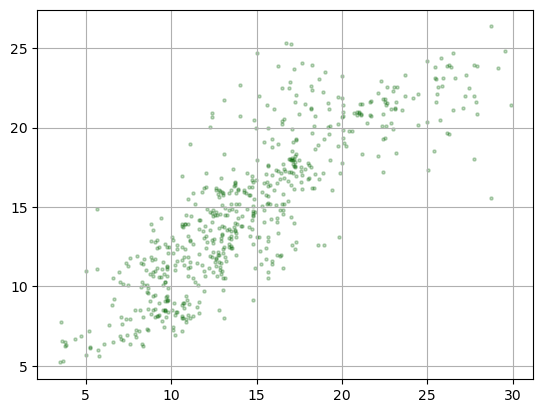

2.8781347510119284
4/4 [==============================] - 0s 7ms/step


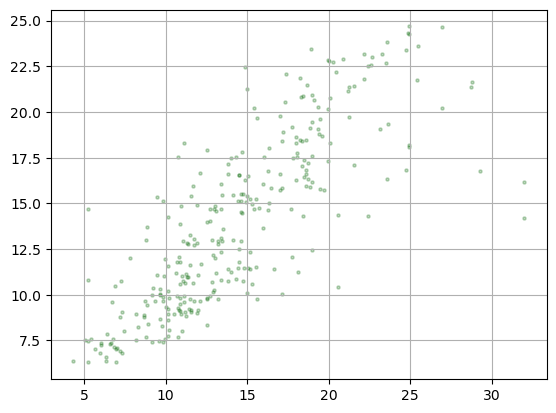

3.211476163507203
2/2 [==============================] - 0s 14ms/step


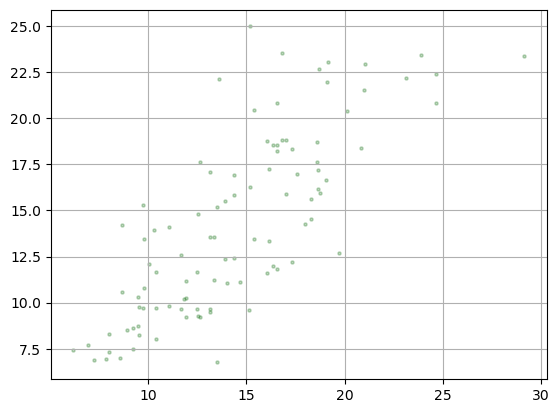

3.1279683538676433
1/1 [==============================] - 0s 19ms/step


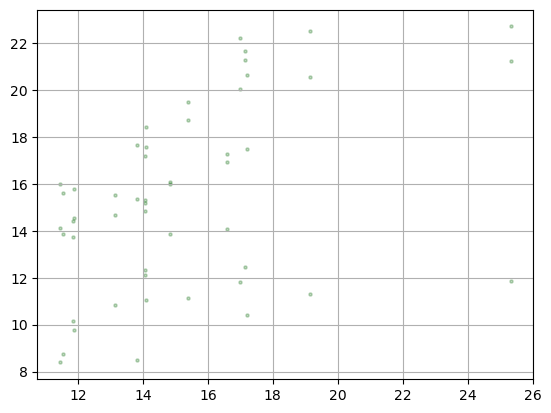

3.8199836781600647


In [51]:
crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : rctest80[system],
                                  'y': ytest[system] }

    
for i in range(7):
    
    ptestnn = modelo_pca80_cs.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='green', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    print(rmse)

crystalsys = {}

for i in range(7):
    system = [dbtest.cs.values == i]
    system = np.array(system)
    system = system.reshape(15454,)
    
    crystalsys[f'system{i}'] = {'x' : rctest95[system],
                                  'y': ytest[system] }

    
for i in range(7):
    
    ptestnn = modelo_pca95_cs.predict(crystalsys[f'system{i}']['x'])
    
    plt.figure()
    plt.scatter(crystalsys[f'system{i}']['y'][:,:3], ptestnn[:,:3], s=5, color='darkgreen', alpha=0.25)
    plt.grid()
    plt.show()
    
    rmse = ((ptestnn[:,:3] - crystalsys[f'system{i}']['y'][:,:3])**2).mean()**0.5
    print(rmse)